In [1]:
import numpy as np
from matplotlib import pyplot as plt

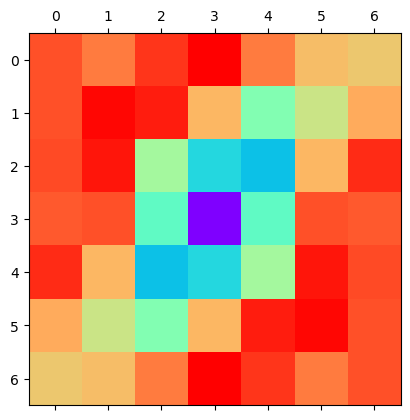

In [2]:
with open("../data/variogram_map.dat", "r") as arq:
    varmap = np.loadtxt(arq, delimiter=",")

plt.matshow(varmap, cmap="rainbow")

In [3]:
def center(varmap):
    M, N = varmap.shape
    return M//2, N//2

def test_center(varmap):
    i, j = center(varmap)
    varmap[i,j] == 0.2
    
test_center(varmap)

In [4]:
def getVariogramByAngle(varmap, angle):
    i_c, j_c = center(varmap)
    M, N = varmap.shape
    
    if angle == 45:
        numLags = min(M-i_c+1,N-j_c)
        variogramValues = np.zeros(numLags)
    
        for i in range(numLags):
            variogramValues[i] = varmap[i_c-i, j_c+i]
    elif angle == -45:
        numLags = min(i_c+1,j_c+1)
        variogramValues = np.zeros(numLags)
    
        for i in range(numLags):
            variogramValues[i] = varmap[i_c-i, j_c-i]
            
    return variogramValues

def test_getVariogramByAngle(varmap):
    np.all(getVariogramByAngle(varmap, angle=45) == np.array([0.2, 0.49, 0.88, 0.95]))
    np.all(getVariogramByAngle(varmap, angle=-45) == np.array([0.2, 0.8, 1.24, 1.14]))

test_getVariogramByAngle(varmap)

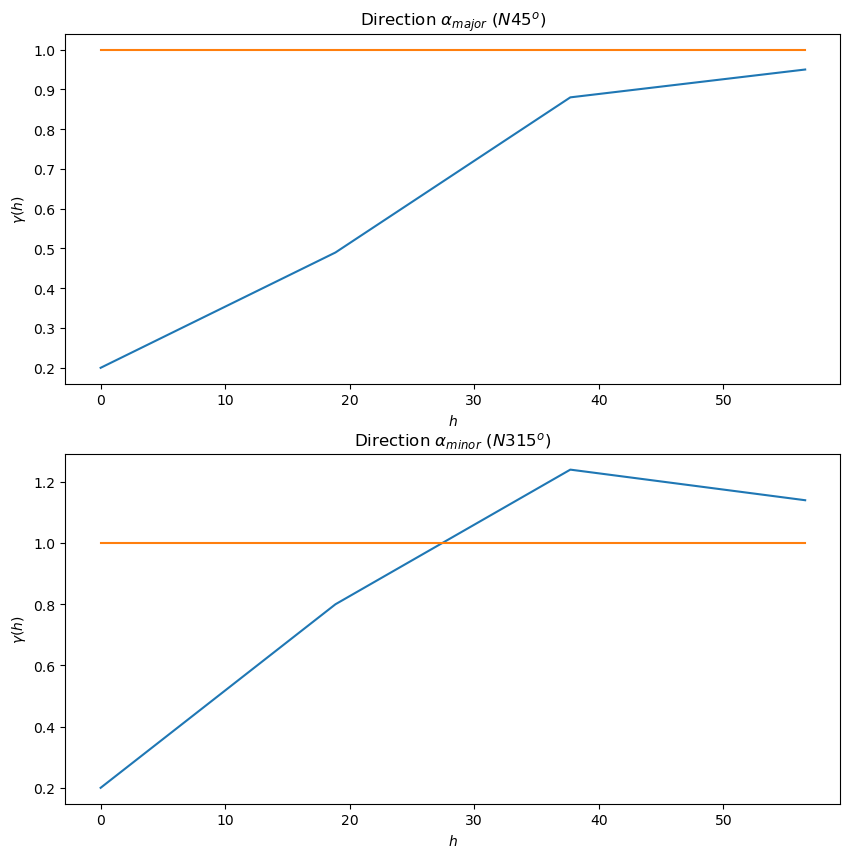

In [15]:
fig, ax = plt.subplots(2)
h = np.linspace(0,4*10*np.sqrt(2), 4)

plt.rcParams["figure.figsize"] = (10,10)
ax[0].plot(h, getVariogramByAngle(varmap, 45))
ax[0].plot(h, np.ones(len(h)))
ax[0].set_title(r"Direction $\alpha_{major}$ ($N45^o$)")
ax[0].set_xlabel(r"$h$")
ax[0].set_ylabel(r"$\gamma(h)$")

ax[1].plot(h, getVariogramByAngle(varmap, -45))
ax[1].plot(h, np.ones(len(h)))
ax[1].set_title(r"Direction $\alpha_{minor}$ ($N315^o$)")
ax[1].set_xlabel(r"$h$")
ax[1].set_ylabel(r"$\gamma(h)$")

plt.savefig("../figs/assignment5-experimental.pdf", dpi=300)

In [6]:
import torch

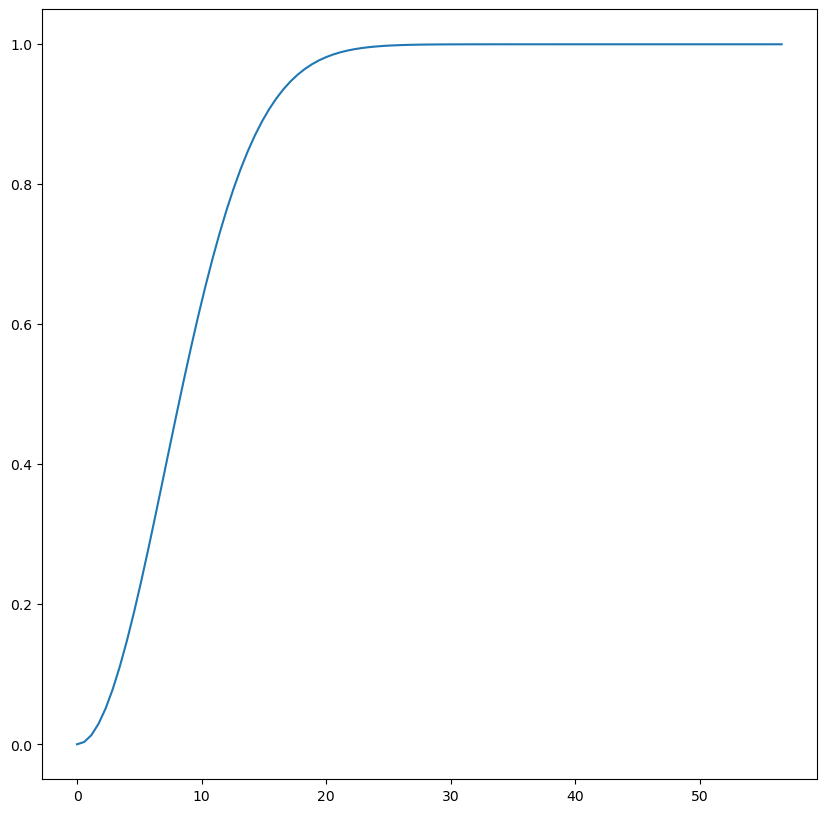

In [7]:
def gauss(h, a, c=1):
    return c * (1-torch.exp(-(3*h)**2/a**2))

def test_gauss():
    h = np.linspace(0,4*10*np.sqrt(2), 100)
    plt.plot(h, gauss(torch.from_numpy(h), 30, 1).numpy())
    
test_gauss()

In [8]:
def nugget(h):
    values = torch.tensor([1.])
    return torch.heaviside(h, values)
    
def test_nugget():
    h = np.linspace(0,4*10*np.sqrt(2), 100)
    plt.plot(h, nugget(torch.from_numpy(h)).numpy())

#test_nugget()

In [9]:
def forward(h, w, a=[30, 30, 30], c=1):
    gamma_h = w[0] + w[1] * gauss(h, a[0]) + w[2] * gauss(h,a[1]) + w[3] * gauss(h,a[2])
    return gamma_h

In [10]:
def loss(y, y_predicted):
    return ((y-y_predicted)**2).mean()

In [11]:
def training(h_t, variogramValues, a, epochs=200, lr=0.002):
    w = torch.tensor([0.1, 0.3, 0.3, 0.3], requires_grad=True)
    for epoch in range(epochs):
        w_s = w.sum()
        w_norm = w.div(w_s)
        gamma_h = forward(h_t, w_norm, a)
        error = loss(variogramValues, gamma_h)
        error.backward()
        with torch.no_grad():
            w -= lr * w.grad
        w.grad.zero_()
    return w_norm.detach()

ranges_major = [35, 50, 60]
ranges_minor = [20, 20, 50]
h_t = torch.linspace(0,4*10*np.sqrt(2), 4)
w_major = training(h_t, torch.from_numpy(getVariogramByAngle(varmap, 45)), a=ranges_major)
w_minor = training(h_t, torch.from_numpy(getVariogramByAngle(varmap, -45)), a=ranges_minor)

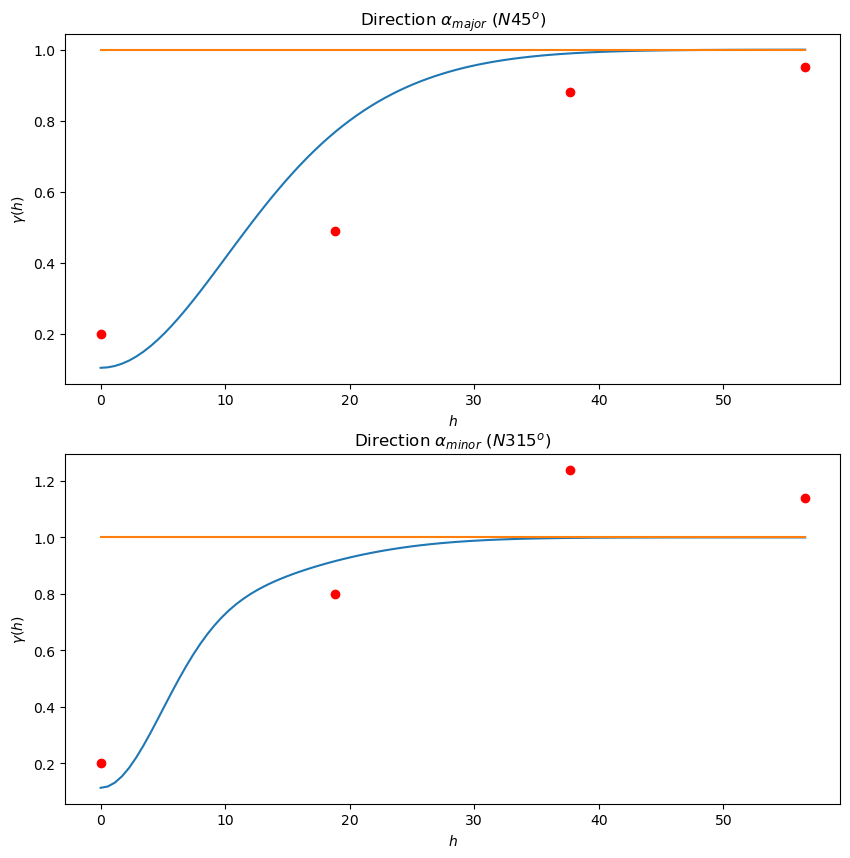

In [12]:
h = np.linspace(0,4*10*np.sqrt(2), 4)
h_t   = torch.linspace(0,4*10*np.sqrt(2), 100)

fig, ax = plt.subplots(2)

ax[0].plot(h_t, forward(h_t, w_major, ranges_major).numpy())
ax[0].scatter(h, getVariogramByAngle(varmap, 45), c="red")
ax[0].plot(h, np.ones(len(h)))
ax[0].set_title(r"Direction $\alpha_{major}$ ($N45^o$)")
ax[0].set_xlabel(r"$h$")
ax[0].set_ylabel(r"$\gamma(h)$")

ax[1].plot(h_t, forward(h_t, w_minor, ranges_minor).numpy())
ax[1].scatter(h, getVariogramByAngle(varmap, -45), c="red")
ax[1].plot(h, np.ones(len(h)))
ax[1].set_title(r"Direction $\alpha_{minor}$ ($N315^o$)")
ax[1].set_xlabel(r"$h$")
ax[1].set_ylabel(r"$\gamma(h)$")

plt.savefig("../figs/assignment5-modeled.pdf", dpi=300)

In [13]:
def correlationMap(varMap, sill=1):
    return np.clip(sill - varmap, 0, 1)

print(correlationMap(varmap))

[[0.   0.   0.   0.   0.   0.03 0.05]
 [0.   0.   0.   0.02 0.27 0.12 0.  ]
 [0.   0.   0.2  0.46 0.51 0.02 0.  ]
 [0.   0.   0.34 0.8  0.34 0.   0.  ]
 [0.   0.02 0.51 0.46 0.2  0.   0.  ]
 [0.   0.12 0.27 0.02 0.   0.   0.  ]
 [0.05 0.03 0.   0.   0.   0.   0.  ]]


In [14]:
def moment_inertia(cormap, direction, dx=10., dy=10.):
    i_c, j_c = center(cormap)
    M, N = cormap.shape
    
    inertia = 0.
    if direction == "horizontal":
        for j in range(N-j_c):
            inertia += cormap[i_c, j_c + j] * (j*dx)**2
    elif direction == "vertical":
        for i in range(M-j_c):
            inertia += cormap[i_c - i, j_c] * (i*dy)**2
    elif direction == "diagonal":
        nIter = min(M-j_c+1, N-j_c)
        for i in range(M-j_c):
            inertia += cormap[i_c - i, j_c + i] * (i*dx*np.sqrt(2))**2
        inertia = -inertia
    return inertia

cormap = correlationMap(varmap)
I_xx = moment_inertia(cormap, "horizontal")
I_yy = moment_inertia(cormap, "vertical")
I_xy = moment_inertia(cormap, "diagonal")

print(I_xx, I_yy, I_xy)

theta = np.arctan(-2*I_xy/(I_xx-I_yy))/2 * 180/np.pi
print(theta)
print(np.tan(2*theta/180*np.pi))
print(np.tan(2*(theta/180*np.pi+np.pi/2)))

34.0 54.00000000000001 -288.0000000000001
-44.005681071762965
-28.799999999999876
-28.79999999999998
